In [1]:
import Pkg
#Pkg.add("StatsBase")
#Pkg.add("Distributions")
#Pkg.add("GraphPlot")
#Pkg.add("Plots")
#Pkg.add("GraphRecipes")
#Pkg.add("NetworkLayout")
#Pkg.add("GeometryTypes")
#Pkg.add("PaddedViews")
#Pkg.add("Cairo")
#Pkg.add("Compose")
#Pkg.add("Plots")
#Pkg.add("PyPlot")
using StatsBase
using Random
using Distributions
using LinearAlgebra
using LightGraphs
#using LightGraphs: smallgraph
using GraphPlot
#using GraphRecipes, Plots
#using NetworkLayout:SFDP
#using GeometryTypes
using PaddedViews
using Cairo, Compose
using Plots


In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))

HTML{String}("<style>.container { width:100% !important; }</style>")

In [3]:
"""
ForSample function https://github.com/JuliaStats/StatsBase.jl/blob/08d4b77a4b42ef8cadb67b98da65e7fbd9959e0b/src/sampling.jl#L445-L456

In our code, we use a simple sample fucntion, which has a stucture below
## sample([rng], a, [wv::AbstractWeights], n::Integer; replace=true, ordered=false) ##

For weight factors [wv::AbstractWeights], please see https://juliastats.org/StatsBase.jl/stable/weights/
There are different weight vectors. the type of weight in our code is Probability weights.
(https://juliastats.org/StatsBase.jl/stable/weights/#ProbabilityWeights-1)
Attention!
U need delcare you weight type in the sample function or the sample function will not take it as a valid input
##
example:(this is invalid) ✘ the right one is in our code.
sample(Grid_Label_flatten::AbstractArray,✘final_probability_flatten✘, amount_panel , replace = false, ordered= true)
##
"""


function Make_Question(n::Int,m::Int,factor::Int = 10, Density::Float64 = 0.8, option::String = "1-norm", distance::Int = 1)
    Grid_Label =  transpose( reshape(  collect(1:n*m),(n,m) ) )
    Grid_Label_flatten = reshape(Grid_Label,(m*n))
    
    px = abs.(((Grid_Label.-1) .% n).-((n-1)/2) )
    py = abs.(((Grid_Label.-1) .÷ n).-((n-1)/2))
    mesh_porbability = factor .^ -(px.+py)
    final_probability = mesh_porbability / sum(mesh_porbability)
    final_probability_flatten= reshape(final_probability, (m*n))
    
    amount_panel = Int(round(Density*n*m))
    
    allocation = sample(Grid_Label_flatten::AbstractArray, ProbabilityWeights(final_probability_flatten), amount_panel , replace = false, ordered= true)
    
    position_y = (allocation.-1).÷ n
    position_x = (allocation.-1).% n
    
    """
    make pairs to such structure to calculate the norm (for instance)
    2×32 Transpose{Int64,Array{Int64,2}}: 
     0  0  0  1  1  1  1  2  2  2  2  3  3  …  4  4  4  5  5  5  5  5  6  6  6  7
     2  3  4  2  3  4  5  2  3  4  5  0  1     3  4  5  0  2  3  4  5  1  2  4  0
    """
    position_pairs_pre = transpose(hcat(position_x,position_y))
    position_pairs = reshape(position_pairs_pre, (1 ,2 ,size(position_x)[1]))
    
    node_number = size(position_x)[1]
    Vector_2d_distance_set = zeros((1,2,node_number,node_number))
    [Vector_2d_distance_set[:,:,:,index] .= position_pairs .- position_pairs[:,:,index] for index in 1:node_number]
    
    norm_distance_set = zeros((node_number,node_number))
    if option == "1-norm"
        
        [norm_distance_set[index,:] .= [norm(slice,1) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]
    
    elseif option == "2-norm"
    
        [norm_distance_set[index,:] .= [norm(slice,2) for slice in eachslice(Vector_2d_distance_set[:,:,:,index], dims=3)] for index in 1:node_number ]
    else
        println("wrong input pal~")
        return 0
    end
    
    #println(position_pairs)
    #println(Vector_2d_distance_set)
    #println(norm_distance_set)
    network_adv = norm_distance_set .<= distance
    
    nodelabel = collect(1:node_number)
    
    return network_adv - I,allocation,node_number,position_x,position_y , nodelabel;
end

Make_Question (generic function with 5 methods)

In [4]:
function Complete_Question(network::Array{Int64,2},allocation::Array{Int64,1},node_number::Int,location_x::Array{Int64,1},
    location_y::Array{Int64,1},location_original::Array{Int64,1})
        #      vertices  x0t|
        #     o | o | * | 1 | 
   #vertices' o | o | * | 1 | Right 1
        #     * | * | * | 1 | 
        #x0t  0 | 0 | 0 | 0 | 
        #    Bottom 2
    
    network_expand_right = PaddedView(1, network, (node_number, node_number + 1))
    network_expand_bottom = PaddedView(0, network_expand_right, (node_number +1 , node_number + 1))
    complete_network = network_expand_bottom
    
    position_x= push!(location_x , location_original[1])
    position_y = push!(location_y , location_original[2])
    
    nodelabel = collect(1:node_number)
    nodelabel = [nodelabel;'a']
    
    return convert(Array{Int64,2},complete_network),position_x,position_y,nodelabel;
end

Complete_Question (generic function with 1 method)

In [5]:
function Fake_complete_Question(network::Array{Int64,2},allocation::Array{Int64,1},node_number::Int,location_x::Array{Int64,1},
    location_y::Array{Int64,1},location_original::Array{Int64,1})
        #      vertices  x0t|
        #     o | o | * | 1 | 
   #vertices' o | o | * | 1 | Right 1
        #     * | * | * | 1 | 
        #x0t  1 | 1 | 1 | 0 | 
        #    Bottom 2
    
    # inorder to enurmate edge
    network = network + I
    network_expand_right = PaddedView(1, network, (node_number, node_number + 1))
    network_expand_bottom = PaddedView(1, network_expand_right, (node_number +1 , node_number + 1))
    complete_network = network_expand_bottom - I
    
    position_x= push!(location_x , location_original[1])
    position_y = push!(location_y , location_original[2])
    
    fake_nodelabel = collect(1:node_number)
    fake_nodelabel = [fake_nodelabel;'a']
    
    return  convert(Array{Int64,2},complete_network),position_x,position_y,fake_nodelabel;
end

Fake_complete_Question (generic function with 1 method)

In [6]:
function Draw_Direct_Graph(complete_network::Array{Int64,2},position_x::Array{Int64,1},position_y::Array{Int64,1},nodelabel::Array)
    k = DiGraph(complete_network)
    println(nodelabel)
    final = gplot(k, position_x,position_y, nodelabel=nodelabel);
    return final;
end

Draw_Direct_Graph (generic function with 1 method)

In [7]:
function Draw_Graph(complete_network::Array{Int64,2},position_x::Array{Int64,1},position_y::Array{Int64,1},nodelabel::Array)
    l = Graph(complete_network)
    println(nodelabel)
    final = gplot(l, position_x,position_y, nodelabel=nodelabel);
    return final;
end

Draw_Graph (generic function with 1 method)

In [66]:
ENV["PYTHON"] = raw"C:\Python38\python.exe" 
Pkg.build("PyCall")
using PyCall
pyplot() #change backend

   Building Conda ─→ `C:\Users\Bastiiii\.julia\packages\Conda\x5ml4\deps\build.log`
   Building PyCall → `C:\Users\Bastiiii\.julia\packages\PyCall\tqyST\deps\build.log`
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260


Plots.PyPlotBackend()

In [67]:
m = 4
n = 4
sub_network,allocation,node_number,loc_x,loc_y,sub_nodelabel = Make_Question(n::Int,m::Int)
# Draw_Graph(sub_network,loc_x,loc_y, sub_nodelabel)

([0 1 … 0 0; 1 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 1 0], [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 13, [1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2], [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [68]:
length(allocation)

13

In [69]:
pos = Dict()
for n in 1:length(allocation)
    #println(n)
    pos[n-1] = (loc_x[n],loc_y[n])
end

print(pos)

Dict{Any,Any}(2 => (0, 1),11 => (1, 3),0 => (1, 0),7 => (1, 2),9 => (3, 2),10 => (0, 3),8 => (2, 2),6 => (0, 2),4 => (2, 1),3 => (1, 1),5 => (3, 1),12 => (2, 3),1 => (2, 0))

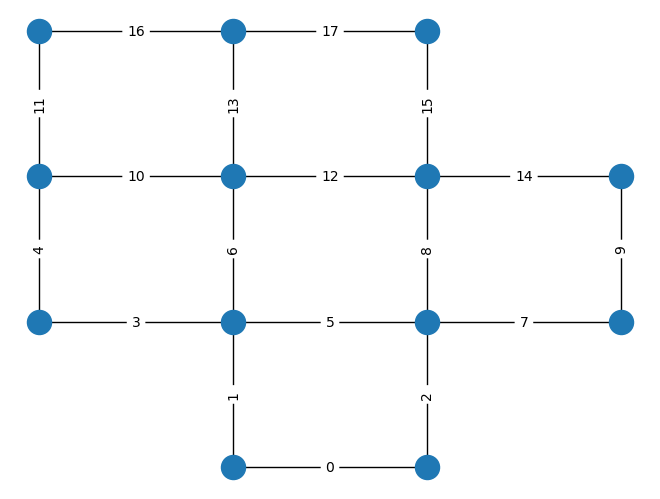

{2: (0, 1), 11: (1, 3), 0: (1, 0), 7: (1, 2), 9: (3, 2), 10: (0, 3), 8: (2, 2), 6: (0, 2), 4: (2, 1), 3: (1, 1), 5: (3, 1), 12: (2, 3), 1: (2, 0)}


0

In [73]:
py"""
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random

def Draw_Graph(network,pos):
    print(pos)
    G = nx.DiGraph()
    G = nx.from_numpy_array(network)
    
    # Label Edge with following rules:
    # 1. num(BUS)<num(branch)
    # 2. priority(BUS)>priority(branch)
    edge_label = {}
    for j, edge in enumerate(G.edges()):
        edge_label.update({(edge[0],edge[1]): str(j)})
        
    nx.draw(G,pos,with_labels=False)
    graph = nx.draw_networkx_edge_labels(G,pos,edge_labels = edge_label)
    #graph = nx.draw_networkx_edge_labels(G,pos)

    return 0
"""
py"Draw_Graph"(sub_network,pos)


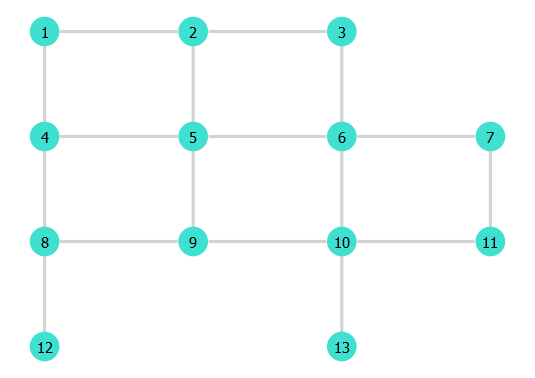

In [2308]:
m = 4
n = 4
sub_network,allocation,node_number,loc_x,loc_y,sub_nodelabel = Make_Question(n::Int,m::Int);
Draw_Graph(sub_network,loc_x,loc_y, sub_nodelabel)

Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'a']


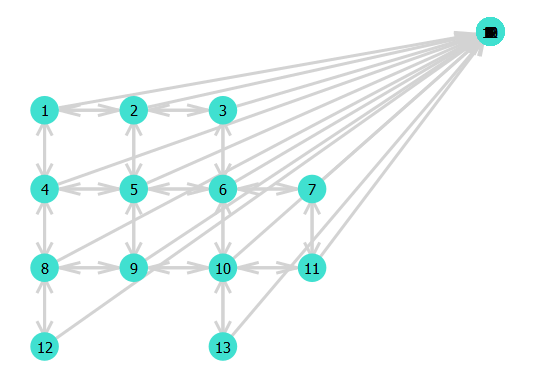

In [2331]:
a,b,c,d = Complete_Question(sub_network,allocation,node_number,loc_x,loc_y,[n+1,-1]);
Draw_Direct_Graph(a,b,c,d)

Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'a']


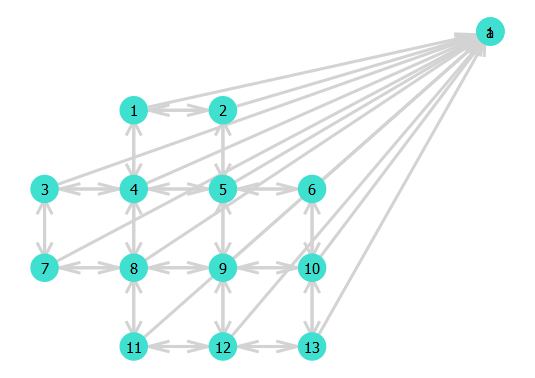

In [2294]:
complete_network,position_x,position_y,nodelabel = Complete_Question(sub_network,allocation,node_number,loc_x,loc_y,[n+1,-1]);
Draw_Direct_Graph(complete_network,position_x,position_y,nodelabel)
#g = DiGraph(complete_network)
#gplot(g,nodelabel=nodelabel)

In [2170]:
nodelabel

14-element Array{Any,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
   'a'

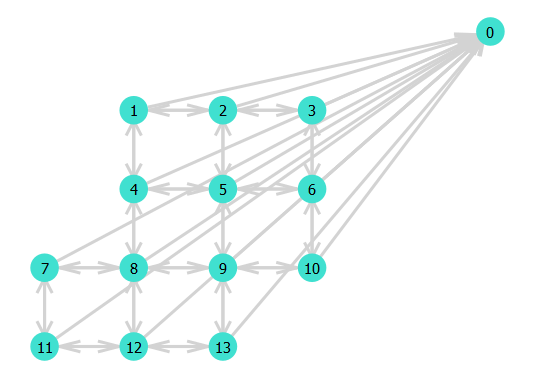

In [2138]:
g = DiGraph(complete_network)
gplot(g, position_x,position_y, nodelabel=nodelabel)

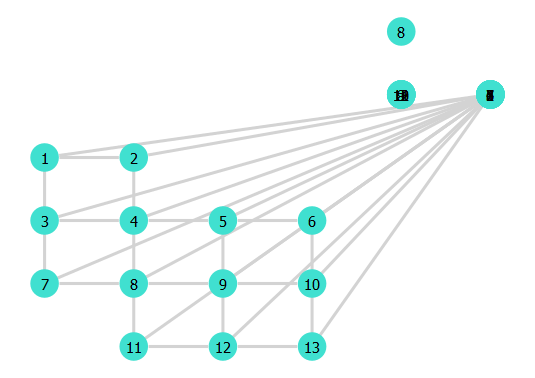

In [2291]:
fake_complete_network,fake_position_x,fake_position_y,fake_nodelabel = Fake_complete_Question(sub_network,allocation,node_number,loc_x,loc_y,[n,-1])
fake_g = Graph(fake_complete_network)
gplot(fake_g, fake_position_x ,fake_position_y, nodelabel = fake_nodelabel)

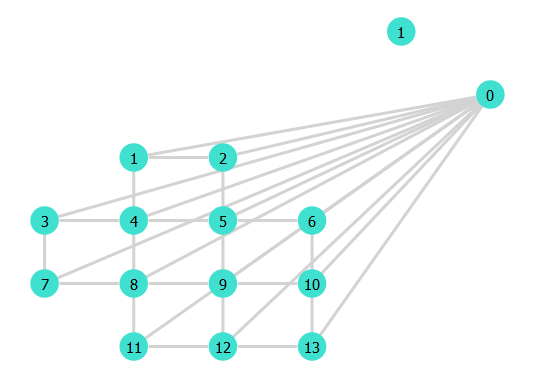

In [1709]:
fake_nodelabel
fake_g
gplot(fake_g, fake_position_x ,fake_position_y, nodelabel = fake_nodelabel)

In [1710]:
fake_nodelabel

14-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
  0

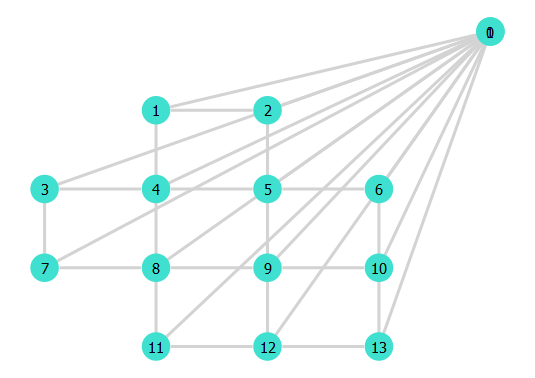

In [695]:
gplot(fake_g, fake_position_x ,fake_position_y, nodelabel = fake_nodelabel)